In [ ]:
import numpy as np
import pandas as pd
import json
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from sklearn.preprocessing import RobustScaler, PowerTransformer

from get_gmp_features import *

: 

In [2]:
def get_features_wrapper(sigmas, orders, path="data/mp_data_forces/MP_data_forces/raw/data_100.json"):
    if isinstance(sigmas, np.ndarray):
        sigmas = sigmas.tolist()
    if isinstance(orders, np.ndarray):
        orders = orders.tolist()
        
    params = {
        "GMPs": {
            "orders": orders,
            "sigmas": sigmas
        },
        # path to the pseudo potential file
        "psp_path": "../GMP-featurizer/pseudopotentials/QE-kjpaw.gpsp",
        # basically the accuracy of the resulting features
        "overlap_threshold": 1e-16,
    }
    
    data = get_data_obj(path)
    featurizer = get_featurizer(params)
    data_list = get_features(data, featurizer, disable=True)
    
    y = [d['y'] for d in data_list]
    y = np.concatenate(y, axis=0)
    
    return y

In [3]:
def get_stats(y):
    var = np.var(y, axis=0)
    std = np.std(y, axis=0)
    mean = np.mean(y, axis=0)
    
    return var, std, mean

In [34]:
def get_sigmas(n_gaussians):
    return np.linspace(0, 0.5, n_gaussians+1, endpoint=True)[1:]

def get_orders(max_order):
    # append -1 to the beginning of the list
    orders = [-1]
    orders.extend([i for i in range(max_order+1)])
    return orders
    # return [i for i in range(max_order+1)]

In [35]:
sigmas = get_sigmas(3)
orders = get_orders(2)

In [36]:
sigmas, orders

(array([0.16666667, 0.33333333, 0.5       ]), [0, 1, 2])

In [37]:
y = get_features_wrapper(sigmas, orders)

Shape of the features:  (47, 9)
Number of errors:  0


In [38]:
var, _, _ = get_stats(y)

print("{:e}".format(np.mean(var)))

1.146721e-02


### Imshow

In [39]:
def get_arrays(n_samples, y):
    selected_indices = np.random.choice(y.shape[0], size=n_samples, replace=False)
    vis_y = y[selected_indices]
    
    min_vals = y.min(axis=0)
    max_vals = y.max(axis=0)
    minmax_array = (y - min_vals) / (max_vals - min_vals)
    minmax_array = minmax_array[selected_indices]

    scaler = RobustScaler()
    robust_array = scaler.fit_transform(y)
    robust_array = robust_array[selected_indices]
    # robust_array = robust_array.tolist()

    log_array = np.log1p(y)
    log_array = log_array[selected_indices]
    
    
    return vis_y, minmax_array, robust_array, log_array

In [40]:
vis_y, minmax_array, robust_array, log_array = get_arrays(50, y)

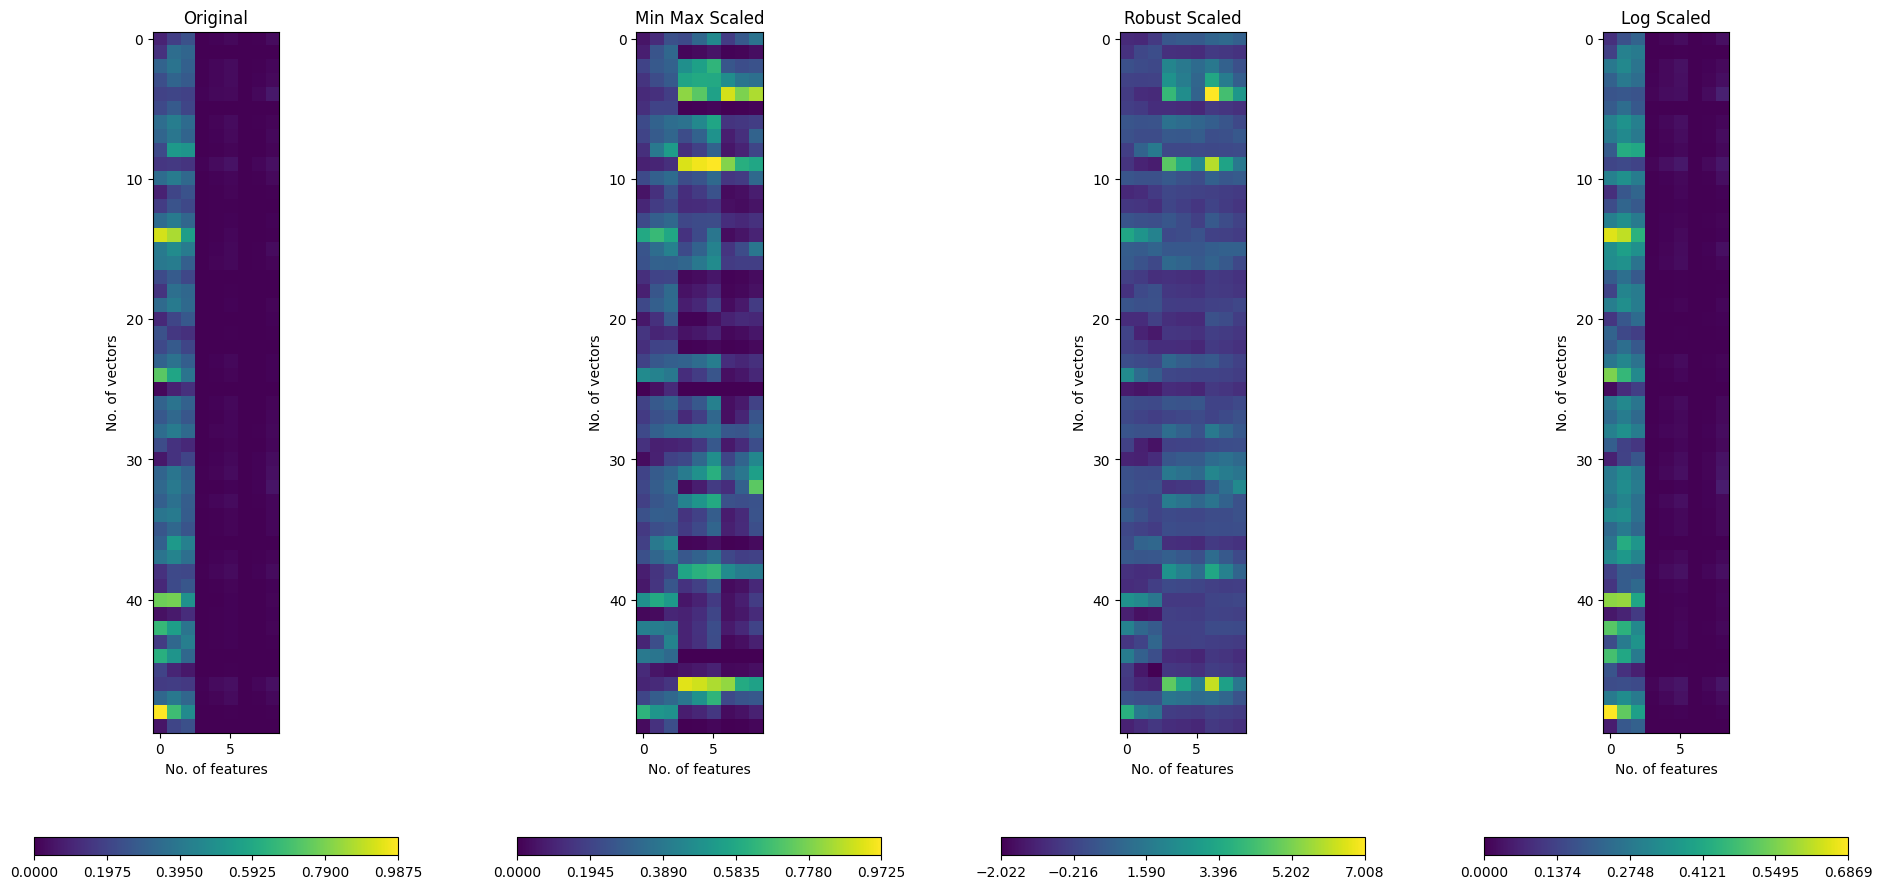

In [41]:
# Create a figure and subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 10))

# Plot the first array on the first subplot
im0 = axes[0].imshow(vis_y, cmap='viridis', interpolation='nearest')
axes[0].set_title('Original')
axes[0].set_xlabel("No. of features")
axes[0].set_ylabel("No. of vectors")

# Plot the second array on the second subplot
im1 = axes[1].imshow(minmax_array, cmap='viridis', interpolation='nearest')
axes[1].set_title('Min Max Scaled')
axes[1].set_xlabel("No. of features")
axes[1].set_ylabel("No. of vectors")

# Plot the third array on the third subplot
im2 = axes[2].imshow(robust_array, cmap='viridis', interpolation='nearest')
axes[2].set_title('Robust Scaled')
axes[2].set_xlabel("No. of features")
axes[2].set_ylabel("No. of vectors")

# Plot the fourth array on the fourth subplot
im3 = axes[3].imshow(log_array, cmap='viridis', interpolation='nearest')
axes[3].set_title('Log Scaled')
axes[3].set_xlabel("No. of features")
axes[3].set_ylabel("No. of vectors")
    
# Create a colorbar for each subplot
cbar0_vals = np.linspace(vis_y.min(), vis_y.max(), 6, endpoint=True)
cbar1_vals = np.linspace(minmax_array.min(), minmax_array.max(), 6, endpoint=True)
cbar2_vals = np.linspace(robust_array.min(), robust_array.max(), 6, endpoint=True)
cbar3_vals = np.linspace(log_array.min(), log_array.max(), 6, endpoint=True)
cbar0 = fig.colorbar(im0, ticks=cbar0_vals, ax=axes[0], orientation='horizontal', shrink=0.7, pad=0.11)
cbar1 = fig.colorbar(im1, ticks=cbar1_vals, ax=axes[1], orientation='horizontal', shrink=0.7, pad=0.11)
cbar2 = fig.colorbar(im2, ticks=cbar2_vals, ax=axes[2], orientation='horizontal', shrink=0.7, pad=0.11)
cbar3 = fig.colorbar(im3, ticks=cbar3_vals, ax=axes[3], orientation='horizontal', shrink=0.7, pad=0.11)


# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# calculate the variance of the minmax and robust scaled arrays
var_minmax, _, _ = get_stats(minmax_array)
var_robust, _, _ = get_stats(robust_array)
var_log, _, _ = get_stats(log_array)
var_regular, _, _ = get_stats(vis_y)

print("Variance of minmax scaled array: {:e}".format(np.mean(var_minmax)))
print("Variance of robust scaled array: {:e}".format(np.mean(var_robust)))
print("Variance of log scaled array: {:e}".format(np.mean(var_log)))
print("Variance of regular array: {:e}".format(np.mean(var_regular)))

Variance of minmax scaled array: 1.199451e-02
Variance of robust scaled array: 1.012135e+00
Variance of log scaled array: 2.380547e-02
Variance of regular array: 7.856169e-01
